# Email Spam Classification
A research by the Radicati Research Group showed that email spams cost businesses up to $20.5 billion annualy (technical expenses, lost of productivity, security breach, pishing). Also the specialized spam website [www.spamlaws.com](https://www.spamlaws.com/spam-stats.html) suggests that spam represents 45\% of all the emails sent. This highlights the importance of making effective spam detection filtering models. 

In this mini-project I will use tensorflow/keras in order to build, train and evaluate a deep-neural network for classifiying emails as ham or spam. I will also use different Natural Language Processing tools such as lemmatization, cleaning, tokenizing, word_embedding in order to improve my model performance.

#### Importing libraries

In [360]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [361]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

# 1 - Data loading, cleaning and Interpretation
#### Data Loading
The data is simply loaded from a csv file with the pandas helper function `read_csv`.
It contains only two columns `Category` where "ham" indicates the email is normal and "spam".

In [362]:
df = pd.read_csv("data/data.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Class imbalance
We notice that the dataset is highly imbalanced. We decide to let the set as it is without providing undersampling/oversampling. Also oversampling the "spam" class would be hard in our case (provided we use text as feature).
We will need to keep this sever imbalance in mind when evaluating our model.

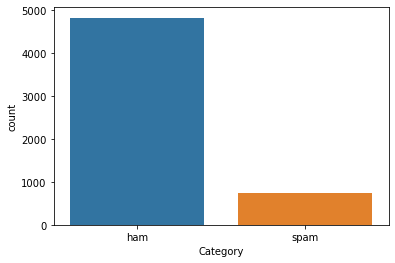

In [363]:
ax = sns.countplot(x = "Category", data = df)

#### Data exploration
We draw the wordcloud of the most common words in messages classified as ham and the one classified as spam. We see that the most frequent words in the spam class are "free", "call", "mobile", "text"

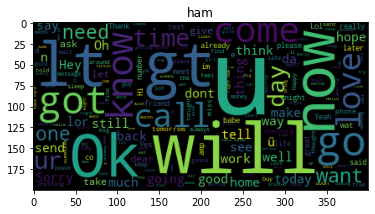

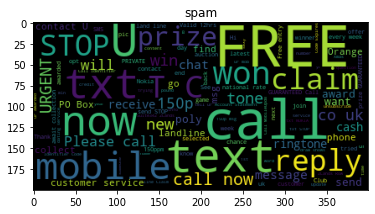

In [364]:
def display_wordcloud(df, title):
    words = " "
    
    for index, row in df.iterrows():
        words += " " + row["Message"]

    word_cloud = WordCloud().generate(words)
    plt.imshow(word_cloud)
    plt.title(title)
    plt.show()
    
def display_wordclouds(df):
    display_wordcloud(df[df["Category"] == "ham"], "ham")
    display_wordcloud(df[df["Category"] == "spam"], "spam")
    
display_wordclouds(df)

#### Data cleaning
First of all we set all words to lower case provided our dataset contains around 5000 samples (In a larger dataset we would not want to do this in order to identify the difference between general & General for example).
Then we remove all the links and everything that is not a letter or a number.

In [365]:
def clean_text(df):
    output = df.copy()
    for index, row in output.iterrows():
        text = row["Message"]
        
        # set to lower case
        text = text.lower()
        
        # remove links
        text = re.sub(r"https://\S+|http://\S+|www.\S+", "", text)
        
        # remove everything that is not a letter or a number
        text = re.sub(r"[^A-Za-z\s+]", "", text)
        
        # tokenize text
        #text_tokenized = word_tokenize(text)
        
        row["Message"] = text
        
    return output

le = LabelEncoder()
        
cleaned_df = clean_text(df)
cleaned_df["Category"] = le.fit_transform(cleaned_df["Category"].to_numpy())

cleaned_df["Category"] = cleaned_df["Category"].map({1:0, 0:1})

cleaned_df.head()

,Category,Message
0,1,go until jurong point crazy available only in ...
1,1,ok lar joking wif u oni
2,0,free entry in a wkly comp to win fa cup final...
3,1,u dun say so early hor u c already then say
4,1,nah i dont think he goes to usf he lives aroun...


Now we want to compute the number of differents words in our corpus (this step is needed for the parameters of the embedding layer)

In [366]:
word_set = set()
maxlen = 0
for index, row in cleaned_df.iterrows():
    text = row["Message"]
    words = text.split()
    n = len(words)
    if n > maxlen:
        maxlen = n
    for word in words:
        word_set.add(word)
        
num_words = len(word_set)

We convert each sample to a vector of number where each word in the corpus is associated to a number with the help of a `Tokenizer`.
Then we pad each vector of number to make every sample the same size

In [367]:
# convert each sample to a vector of number
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(cleaned_df["Message"].to_numpy())
X = tokenizer.texts_to_sequences(cleaned_df["Message"].to_numpy())

# pad each sample 
X = pad_sequences(X, maxlen = maxlen, padding = "post")

We make a 2/3 1/3 train test split

In [368]:
X_train, X_test, y_train, y_test = train_test_split(X, cleaned_df["Category"], test_size = 0.33, shuffle = True)

# 2 - Building and training the model
We create a keras deep-neural network with:
- 1 `Embedding` layer: this will convert each word in a sample to a vector in the embedding space (i.e. performs word2vec, two vectors are close to each others in the embedding space iff they have similar meaning)
- 1 `Dropout` layer: we dropout 20% of our input for each batch
- 1 `Flatten` layer: the embedding layer has a multi-dimentional output which we need to flatten before passing to a fully connected layer
- 1 `Dense` layer: we add a fully connected layer
- 1 `Dropout` layer: we drop 50% of the neurons of the last layer at random
- 1 `Dense` layer: this is the classification layer with a sigmoid activation function

In [369]:
embedding_dim = 32

model = Sequential()
model.add(layers.Embedding(input_dim = num_words + 1, 
                          output_dim = embedding_dim, 
                          input_length = maxlen))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(optimizer = "adam", 
              loss = "binary_crossentropy",
              metrics = ["accuracy", tf.keras.metrics.Recall(class_id = 0)])

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 171, 32)           274560    
_________________________________________________________________
dropout_20 (Dropout)         (None, 171, 32)           0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 5472)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 20)                109460    
_________________________________________________________________
dropout_21 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 21        
Total params: 384,041
Trainable params: 384,041
Non-trainable params: 0
_______________________________________________

We train our model with 5 epochs and a batch size of 10 in order to make it converge faster

In [370]:
history = model.fit(X_train, y_train, 
                   epochs = 5,
                   validation_data = (X_test, y_test),
                   batch_size = 10)

Epoch 1/5
374/374 [==============================] - 2s 5ms/step - loss: 0.2719 - accuracy: 0.8786 - recall_11: 0.9978 - val_loss: 0.1589 - val_accuracy: 0.9516 - val_recall_11: 1.0000
Epoch 2/5
374/374 [==============================] - 2s 4ms/step - loss: 0.1364 - accuracy: 0.9751 - recall_11: 0.9982 - val_loss: 0.1396 - val_accuracy: 0.9755 - val_recall_11: 0.9994
Epoch 3/5
374/374 [==============================] - 2s 4ms/step - loss: 0.0930 - accuracy: 0.9879 - recall_11: 0.9963 - val_loss: 0.1056 - val_accuracy: 0.9772 - val_recall_11: 0.9994
Epoch 4/5
374/374 [==============================] - 1s 4ms/step - loss: 0.0543 - accuracy: 0.9920 - recall_11: 0.9966 - val_loss: 0.0930 - val_accuracy: 0.9804 - val_recall_11: 0.9975
Epoch 5/5
374/374 [==============================] - 1s 4ms/step - loss: 0.0455 - accuracy: 0.9938 - recall_11: 0.9960 - val_loss: 0.1029 - val_accuracy: 0.9810 - val_recall_11: 0.9987


#### Avoiding overfitting
We plot the training loss/validation loss and training accuracy/validation accuracy in order to know when to stop training our model (i.e. when it starts to overfit). We see that the validation loss starts to increase at the second epoch. Therefore we need to train our model for only 2 epochs

58/58 [==============================] - 0s 1ms/step - loss: 0.1536 - accuracy: 0.9782 - recall_10: 0.9981
0.15361718833446503


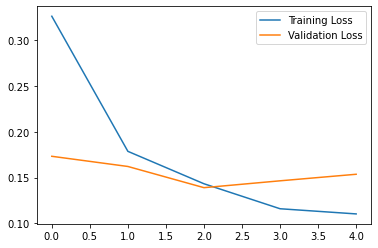

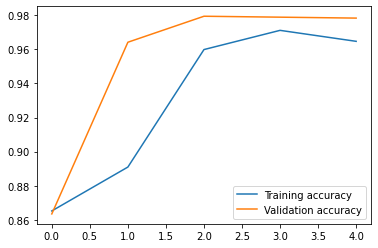

accuracy is 0.9782490730285645


In [350]:
loss, accuracy, recall = model.evaluate(X_test, y_test)
print(loss)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

print(f"accuracy is {accuracy}")

# Model evaluation
We need to be very cautious while evaluating our model as our data is strongly imbalanced. In this case it is not advised to look at the accuracy but rather at the confusion matrix and sensibility/specificity.

#### Receiver Operating Characteristic
We plot the ROC for our classifier and obtain an area under the curve of 0.977 which means our classifier is very skilled.

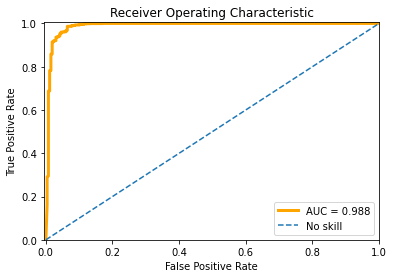

In [374]:
y_pred = model.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, linewidth = 3, color = "orange", label = f"AUC = {roc_auc:.3f}")
baseline_x = np.linspace(0, 1, 10)
plt.plot(baseline_x, baseline_x, label = "No skill", linestyle = "dashed")

plt.plot()
plt.xlim([-0.005, 1])
plt.ylim([0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()


#### Confusion matrix, sensitivity/specificity, false positive rate
Our model has high sensitivity and specificity.
In our case we also suppose that a false negative is more costly than a false positive (an undetected spam is more costly than a legit email detected as spam).
Therefore it is important to have a low false negative rate (high recall for the positive class, i.e. our model catch the most spams possible).

In [375]:
threshold = 0.5
y_pred = (y_pred > 0.5).astype(int)

matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(matrix, "\n")
TP, FP, FN, TN = matrix.ravel()

sensitivity = TP / (TP + FP) # precision of the positive class
specificity = TN / (TN + FN) # precision of the negative class
recall_pos = TP / (TP + FN)
recall_neg = TN / (TN + FP)

print(f"sensitivity of the model {sensitivity}")
print(f"specificity of the model {specificity}")
print(f"recall for the positive class {recall_pos}")
print(f"recall for the negative class {recall_neg}")

Confusion matrix:
[[ 231   33]
 [   2 1573]] 

sensitivity of the model 0.875
specificity of the model 0.9987301587301587
recall for the positive class 0.9914163090128756
recall for the negative class 0.9794520547945206


# 4 - Conclusion
We're able to train a pretty skilled model for detecting spam. We achieve a 0.875 sensitivity (precision for the positive class) and a 0.99873 specificity (precision for the negative class) while having a recall of 0.9914 for the positive class and a recall of 0.979 for the negative class.

A recall of 0.9914 for the positive class means that we will have less than 1 spam email classified as non-spam for every 100 spams we receive. This is pretty good

However, a recall for the negative class of 0.979 means that we will have approximately 20 non-spam emails sclassified as spam for every 1000 non-spam emails received (i.e. 2 for every 100 received). This is still a non-negligeable number this is why our model still has room for improvement.